# Enhanced Static Gesture Recognition using OpenCV, MediaPipe and Dual Models

This notebook demonstrates how to create a static gesture recognition system using:
- OpenCV for webcam capture and image processing
- MediaPipe for detecting body pose and hand landmarks
- Two complementary classifiers for improved accuracy:
  - A TensorFlow-based keypoint classifier
  - A scikit-learn classifier (SVM or Random Forest)

You'll be able to collect your own training data from webcam, extract features, train both models, and combine their predictions for more robust recognition.

## 1. Install Required Libraries

In [9]:
!pip install tensorflow==2.18 --user
#!pip install opencv-python mediapipe numpy scikit-learn pandas matplotlib tensorflow

  Using cached keras-3.9.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached rich-14.0.0-py3-none-any.whl.metadata (18 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ---------------------------------------- 0.0/390.2 MB ? eta -:--:--
   ---------------------------------------- 0.8/390.2 MB 8.3 MB/s eta 0:00:47
   ---------------------------------------- 1.8/390.2 MB 4.4 MB/s eta 0:01:29
   ---------------------------------------- 3.1/390.2 MB 5.1 MB/s eta 0:01:16
   ---------------------------------------- 3.9/390.2 MB 5.0 MB/s eta 0:01:18
    --------------------------------------- 5.0/390.2 MB 4.8 MB/s eta 0:01:21
    --------------------------------------- 5.8/390.2 MB 4.7 MB/s eta 0:01:22
    --------------------------------------- 6.6/390.2 MB 4.7 MB/s eta 0:01:22
    --------------------------------------- 7.6/390.2 MB 4.7 M

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  You can safely remove it manually.


## 2. Import Libraries

In [29]:
pip cache purge  # Remove cached packages

Note: you may need to restart the kernel to use updated packages.


ERROR: Too many arguments


In [14]:
pip uninstall -y tensorflow tensorflow-estimator tensorflow-io tensorflow-intel tf-nightly

Found existing installation: tensorflow 2.13.0
Uninstalling tensorflow-2.13.0:
  Successfully uninstalled tensorflow-2.13.0
Found existing installation: tensorflow-estimator 2.13.0
Uninstalling tensorflow-estimator-2.13.0:
  Successfully uninstalled tensorflow-estimator-2.13.0
Found existing installation: tensorflow-intel 2.13.0
Uninstalling tensorflow-intel-2.13.0:
  Successfully uninstalled tensorflow-intel-2.13.0
Note: you may need to restart the kernel to use updated packages.


In [8]:
!pip install torch

  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
   ---------------------------------------- 0.0/204.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/204.2 MB ? eta -:--:--
   ---------------------------------------- 1.3/204.2 MB 4.2 MB/s eta 0:00:49
   ---------------------------------------- 2.4/204.2 MB 4.5 MB/s eta 0:00:46
    --------------------------------------- 3.4/204.2 MB 4.5 MB/s eta 0:00:45
    --------------------------------------- 3.9/204.2 MB 4.3 MB/s eta 0:00:47
    --------------------------------------- 4.2/204.2 MB 3.9 MB/s eta 0:00:52
    --------------------------------------- 4.7/204.2 MB 3.6 MB/s eta 0:00:56
    --------------------------------------- 5.0/204.2 MB 3.4 MB/s eta 0:01:00
   - -------------------------------------- 5.2/204.2 MB 3.1 MB/s eta 0:01:04
   - -------------------------------------- 5.5/204.2 MB 2.8 MB/s eta 0:01:11
   - -------------------------------------- 5.8/204.2 MB 2.6 MB/s eta 0:01:17
   

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.13.2 which is incompatible.


In [3]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import time
import os
from datetime import datetime
import matplotlib.pyplot as plt
import torch  # Changed from tensorflow to torch
import torch.nn as nn  # Added PyTorch neural network module
import torch.optim as optim  # Added PyTorch optimizer
from torch.utils.data import DataLoader, TensorDataset  # Added PyTorch data utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import seaborn as sns
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)  # Changed from tf.random.set_seed to torch.manual_seed

## 3. Define File Paths

In [4]:
# Create directories if they don't exist
os.makedirs('model/keypoint_classifier', exist_ok=True)
os.makedirs('gesture_data', exist_ok=True)
# Define file paths
dataset_path = 'gesture_data'
keypoint_csv = 'model/keypoint_classifier/keypoint.csv'
keypoint_model_save_path = 'model/keypoint_classifier/keypoint_classifier.pth'  # Changed from .hdf5 to .pth
sklearn_model_save_path = 'model/sklearn_classifier/sklearn_classifier.pkl'
scaler_save_path = 'model/sklearn_classifier/scaler.pkl'


## 4. Initialize MediaPipe

In [5]:
# Initialize MediaPipe Pose and Hands solutions
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands

# Define drawing specs
pose_drawing_spec = mp_drawing.DrawingSpec(thickness=2, circle_radius=2, color=(0, 255, 0))
hand_drawing_spec = mp_drawing.DrawingSpec(thickness=2, circle_radius=2, color=(0, 0, 255))
connection_drawing_spec = mp_drawing.DrawingSpec(thickness=1, color=(255, 0, 0))

## 5. Create Feature Extraction Functions

In [6]:
def extract_landmarks(results):
    """Extract pose and hand landmarks from MediaPipe results"""
    features = []
    
    # Extract pose landmarks (33 landmarks × 3 coordinates = 99 features)
    if results.pose_landmarks:
        for landmark in results.pose_landmarks.landmark:
            features.extend([landmark.x, landmark.y, landmark.z])
    else:
        # If no pose detected, fill with zeros
        features.extend([0.0] * (33 * 3))
    
    # Extract left hand landmarks (21 landmarks × 3 coordinates = 63 features)
    left_hand_found = False
    if results.multi_hand_landmarks:
        for hand_idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
            handedness = results.multi_handedness[hand_idx].classification[0].label
            if handedness == "Left":
                left_hand_found = True
                for landmark in hand_landmarks.landmark:
                    features.extend([landmark.x, landmark.y, landmark.z])
                break
    
    if not left_hand_found:
        # If no left hand detected, fill with zeros
        features.extend([0.0] * (21 * 3))
    
    # Extract right hand landmarks (21 landmarks × 3 coordinates = 63 features)
    right_hand_found = False
    if results.multi_hand_landmarks:
        for hand_idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
            handedness = results.multi_handedness[hand_idx].classification[0].label
            if handedness == "Right":
                right_hand_found = True
                for landmark in hand_landmarks.landmark:
                    features.extend([landmark.x, landmark.y, landmark.z])
                break
    
    if not right_hand_found:
        # If no right hand detected, fill with zeros
        features.extend([0.0] * (21 * 3))
    
    return features

def normalize_landmarks(features):
    """Normalize landmarks relative to the body to make them scale and position invariant"""
    normalized_features = []
    
    # If we have valid pose data (check if not all zeros)
    if not all(f == 0 for f in features[:99]):
        # Use shoulders as reference points for normalization
        left_shoulder_x = features[33]  # left_shoulder x (11th landmark)
        left_shoulder_y = features[34]  # left_shoulder y
        right_shoulder_x = features[36]  # right_shoulder x (12th landmark)
        right_shoulder_y = features[37]  # right_shoulder y
        
        # Calculate shoulder width for scale normalization
        shoulder_width = np.sqrt((right_shoulder_x - left_shoulder_x)**2 + 
                                (right_shoulder_y - left_shoulder_y)**2)
        
        # Calculate midpoint between shoulders as reference point
        ref_x = (left_shoulder_x + right_shoulder_x) / 2
        ref_y = (left_shoulder_y + right_shoulder_y) / 2
        
        # Normalize all landmarks
        for i in range(0, len(features), 3):
            if shoulder_width > 0:
                # Normalize x and y coordinates relative to shoulder midpoint and width
                normalized_features.append((features[i] - ref_x) / shoulder_width)
                normalized_features.append((features[i+1] - ref_y) / shoulder_width)
                # Keep z values but normalize by shoulder width for scale invariance
                normalized_features.append(features[i+2] / shoulder_width)
            else:
                # If reference points are invalid, keep original values
                normalized_features.extend(features[i:i+3])
    else:
        # If no valid pose data, return original features
        normalized_features = features
        
    return normalized_features

def extract_keypoint_format_features(results):
    """Extract only hand landmarks in keypoint format (21 landmarks x 2 coordinates = 42 features)
    This is compatible with the keypoint_classifier model format"""
    features = []
    
    # We'll focus on the right hand for the keypoint classifier
    right_hand_found = False
    if results.multi_hand_landmarks:
        for hand_idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
            handedness = results.multi_handedness[hand_idx].classification[0].label
            if handedness == "Right":
                right_hand_found = True
                # Extract only x and y coordinates
                for landmark in hand_landmarks.landmark:
                    features.extend([landmark.x, landmark.y])
                break
    
    if not right_hand_found:
        # If no right hand detected, fill with zeros
        features.extend([0.0] * (21 * 2))
    
    return features

def normalize_keypoint_features(features):
    """Normalize hand keypoints to be scale and position invariant"""
    # Check if we have valid hand data
    if len(features) == 0 or all(f == 0 for f in features):
        return [0.0] * len(features)
    
    # Reshape to separate x and y coordinates
    keypoints = np.array(features).reshape(-1, 2)
    
    # Get bounding box of hand
    x_min, y_min = np.min(keypoints, axis=0)
    x_max, y_max = np.max(keypoints, axis=0)
    
    # Calculate center and size
    center_x = (x_min + x_max) / 2
    center_y = (y_min + y_max) / 2
    scale = max(x_max - x_min, y_max - y_min)
    
    # Normalize keypoints
    normalized_keypoints = []
    if scale > 0:
        for i in range(0, len(features), 2):
            normalized_keypoints.append((features[i] - center_x) / scale)
            normalized_keypoints.append((features[i+1] - center_y) / scale)
    else:
        normalized_keypoints = features
    
    return normalized_keypoints

## 6. Data Collection Function

In [7]:
def collect_training_data(gesture_name, num_samples=100, countdown=5):
    """Collect training data for a specific gesture"""
    # Create directory for saving data if it doesn't exist
    os.makedirs('gesture_data', exist_ok=True)
    
    # Initialize data structures to store both feature formats
    data_full = []        # Full features (pose + hands)
    data_keypoint = []    # Keypoint features (just hand)
    labels = []
    sample_count = 0
    
    # Initialize webcam
    cap = cv2.VideoCapture(0)
    
    # Countdown before starting data collection
    start_time = time.time()
    countdown_complete = False
    
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose, \
         mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:
        
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                print("Failed to capture image from webcam.")
                break
                
            # Flip the image horizontally for a selfie-view display
            image = cv2.flip(image, 1)
            
            # Convert the BGR image to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Process the image for pose and hand detection
            pose_results = pose.process(image_rgb)
            hands_results = hands.process(image_rgb)
            
            # Copy original image for display
            display_image = image.copy()
            
            # Check countdown status
            current_time = time.time()
            elapsed_time = current_time - start_time
            
            if not countdown_complete:
                remaining = countdown - int(elapsed_time)
                if remaining > 0:
                    # Display countdown
                    cv2.putText(display_image, f"Get ready! Starting in {remaining}...", (50, 50),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                else:
                    countdown_complete = True
            
            # If countdown is complete, start collecting data
            if countdown_complete:
                # Create a combined result object to pass to the feature extraction functions
                combined_results = type('CombinedResults', (), {
                    'pose_landmarks': pose_results.pose_landmarks if pose_results.pose_landmarks else None,
                    'multi_hand_landmarks': hands_results.multi_hand_landmarks if hands_results.multi_hand_landmarks else None,
                    'multi_handedness': hands_results.multi_handedness if hands_results.multi_handedness else None
                })
                
                # Extract full features (pose + hands)
                features_full = extract_landmarks(combined_results)
                normalized_features_full = normalize_landmarks(features_full)
                
                # Extract keypoint features (just hand)
                features_keypoint = extract_keypoint_format_features(combined_results)
                normalized_features_keypoint = normalize_keypoint_features(features_keypoint)
                
                # Append to our datasets
                data_full.append(normalized_features_full)
                data_keypoint.append(normalized_features_keypoint)
                labels.append(gesture_name)
                sample_count += 1
                
                # Display progress
                cv2.putText(display_image, f"Collecting: {gesture_name} - {sample_count}/{num_samples}", (50, 50),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            # Draw landmarks on the image
            if pose_results.pose_landmarks:
                mp_drawing.draw_landmarks(
                    display_image,
                    pose_results.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=pose_drawing_spec,
                    connection_drawing_spec=connection_drawing_spec)
            
            if hands_results.multi_hand_landmarks:
                for hand_landmarks in hands_results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(
                        display_image,
                        hand_landmarks,
                        mp_hands.HAND_CONNECTIONS,
                        landmark_drawing_spec=hand_drawing_spec,
                        connection_drawing_spec=connection_drawing_spec)
            
            # Show the image
            cv2.imshow('MediaPipe Pose and Hands', display_image)
            
            # Check if we've collected enough samples
            if sample_count >= num_samples:
                break
                
            # Exit if ESC key is pressed
            if cv2.waitKey(5) & 0xFF == 27:
                break
    
    # Release resources
    cap.release()
    cv2.destroyAllWindows()
    
    # Save collected data
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"gesture_data/{gesture_name}_{timestamp}.pkl"
    
    with open(filename, 'wb') as f:
        pickle.dump({
            'data_full': data_full, 
            'data_keypoint': data_keypoint, 
            'labels': labels
        }, f)
    
    print(f"Collected {sample_count} samples for gesture '{gesture_name}'")
    print(f"Data saved to {filename}")
    
    return data_full, data_keypoint, labels

## 7. Collect Training Data

Run the cell below for each gesture you want to train. Change the `gesture_name` and `num_samples` parameters as needed.

In [52]:
# Example: Collect data for a "Wave" gesture
# Replace "wave" with your desired gesture name
data_full, data_keypoint, labels = collect_training_data(gesture_name="Water", num_samples=100)

Collected 100 samples for gesture 'Water'
Data saved to gesture_data/Water_20250419_225838.pkl


## 8. Combine All Collected Data

In [53]:
def combine_gesture_data(data_dir='gesture_data'):
    """Combine all gesture data files into a single dataset"""
    all_data_full = []
    all_data_keypoint = []
    all_labels = []
    
    # Check if directory exists
    if not os.path.exists(data_dir):
        print(f"Error: Directory '{data_dir}' does not exist.")
        return None, None, None
    
    # Get all pickle files in the directory
    files = [f for f in os.listdir(data_dir) if f.endswith('.pkl')]
    
    if not files:
        print(f"No data files found in '{data_dir}'")
        return None, None, None
    
    # Load and combine all data
    for file in files:
        file_path = os.path.join(data_dir, file)
        try:
            with open(file_path, 'rb') as f:
                data_dict = pickle.load(f)
                
                # Handle both old and new data formats
                if 'data_full' in data_dict and 'data_keypoint' in data_dict:
                    # New format with both feature types
                    all_data_full.extend(data_dict['data_full'])
                    all_data_keypoint.extend(data_dict['data_keypoint'])
                    all_labels.extend(data_dict['labels'])
                elif 'data' in data_dict:
                    # Old format - assume it's full data only
                    print(f"Warning: {file} uses an old format. Skipping keypoint data.")
                    all_data_full.extend(data_dict['data'])
                    all_labels.extend(data_dict['labels'])
                else:
                    print(f"Warning: {file} has an unknown format.")
                    continue
                    
            print(f"Loaded {len(data_dict['labels'])} samples from {file}")
        except Exception as e:
            print(f"Error loading {file}: {e}")
    
    # If keypoint data is missing, generate dummy data
    if all_data_full and not all_data_keypoint:
        print("Warning: No keypoint data found. Generating dummy keypoint data.")
        all_data_keypoint = [[0.0] * 42 for _ in range(len(all_data_full))]
    
    print(f"Combined dataset has {len(all_data_full)} samples across {len(set(all_labels))} gesture classes")
    
    return all_data_full, all_data_keypoint, all_labels

# Combine all collected data
all_data_full, all_data_keypoint, all_labels = combine_gesture_data()

Loaded 100 samples from Food_20250419_225809.pkl
Loaded 100 samples from How_20250419_225521.pkl
Loaded 100 samples from I_20250419_225147.pkl
Loaded 100 samples from Know_20250419_225242.pkl
Loaded 100 samples from speak_20250419_223419.pkl
Loaded 100 samples from Water_20250419_225838.pkl
Loaded 100 samples from wave_20250419_223306.pkl
Loaded 100 samples from You_20250419_225214.pkl
Combined dataset has 800 samples across 8 gesture classes


## 9. Create CSV File for Keypoint Classifier

In [54]:
import csv
def create_keypoint_csv(data_keypoint, labels, output_file=keypoint_csv):
    """Create CSV file for the keypoint classifier training"""
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    # Convert labels to numeric IDs
    unique_labels = sorted(list(set(labels)))
    label_to_id = {label: i for i, label in enumerate(unique_labels)}
    
    # Create CSV file
    with open(output_file, 'w', newline='') as f:
        writer = csv.writer(f)
        for i, (features, label) in enumerate(zip(data_keypoint, labels)):
            row = [label_to_id[label]] + features
            writer.writerow(row)
    
    print(f"Created keypoint CSV file at {output_file}")
    print(f"Label mapping: {label_to_id}")
    
    # Save label mapping for future reference
    label_map_file = os.path.join(os.path.dirname(output_file), 'label_map.pkl')
    with open(label_map_file, 'wb') as f:
        pickle.dump({
            'label_to_id': label_to_id,
            'id_to_label': {i: label for label, i in label_to_id.items()}
        }, f)
    
    return label_to_id, unique_labels

# Create CSV file for keypoint classifier if we have data
if all_data_keypoint and all_labels:
    label_to_id, unique_labels = create_keypoint_csv(all_data_keypoint, all_labels)
    NUM_CLASSES = len(unique_labels)
    print(f"Number of classes: {NUM_CLASSES}")
else:
    print("No data available for creating keypoint CSV.")

Created keypoint CSV file at model/keypoint_classifier/keypoint.csv
Label mapping: {'Food': 0, 'How': 1, 'I': 2, 'Know': 3, 'Water': 4, 'You': 5, 'speak': 6, 'wave': 7}
Number of classes: 8


## 10. Train Keypoint Classifier (TensorFlow Model)

In [55]:
def train_keypoint_classifier(csv_file=keypoint_csv, model_save_path=keypoint_model_save_path):
    """Train the keypoint classifier using PyTorch"""
    # Create directories if they don't exist
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    
    # Load data from CSV
    X_dataset = np.loadtxt(csv_file, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
    y_dataset = np.loadtxt(csv_file, delimiter=',', dtype='int32', usecols=(0))
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
       X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)
    
    # Get the number of classes
    num_classes = len(np.unique(y_dataset))
    
    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test)
    
    # Create TensorDatasets and DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    # Define the model using PyTorch's nn.Module
    class KeypointClassifier(nn.Module):
        def __init__(self, input_size, hidden_size_1, hidden_size_2, num_classes, dropout_1=0.2, dropout_2=0.4):
            super(KeypointClassifier, self).__init__()
            self.dropout1 = nn.Dropout(dropout_1)
            self.fc1 = nn.Linear(input_size, hidden_size_1)
            self.dropout2 = nn.Dropout(dropout_2)
            self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
            self.fc3 = nn.Linear(hidden_size_2, num_classes)
            self.relu = nn.ReLU()
        
        def forward(self, x):
            x = self.dropout1(x)
            x = self.relu(self.fc1(x))
            x = self.dropout2(x)
            x = self.relu(self.fc2(x))
            x = self.fc3(x)
            return x
    
    # Instantiate the model
    model = KeypointClassifier(
        input_size=21 * 2,
        hidden_size_1=20,
        hidden_size_2=10,
        num_classes=num_classes
    )
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    # Training parameters
    epochs = 100
    patience = 20
    best_val_loss = float('inf')
    counter = 0
    
    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        train_loss = running_loss / len(train_loader.dataset)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(test_loader.dataset)
        val_acc = correct / total
        
        print(f'Epoch {epoch+1}/{epochs}: '
              f'Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, '
              f'Val Acc: {val_acc:.4f}')
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            # Save the best model
            torch.save(model.state_dict(), model_save_path)
            print(f"Model improved, saving to {model_save_path}")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Final evaluation
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    final_acc = correct / total
    print(f"Final validation accuracy: {final_acc:.4f}")
    
    print(f"Model saved to {model_save_path}")
    
    return model

# Train the keypoint classifier if CSV file exists
if os.path.exists(keypoint_csv):
    keypoint_model = train_keypoint_classifier()
else:
    print("Keypoint CSV file not found. Please create it first.")
    keypoint_model = None

Epoch 1/100: Train Loss: 2.0912, Val Loss: 2.0833, Val Acc: 0.1500
Model improved, saving to model/keypoint_classifier/keypoint_classifier.pth
Epoch 2/100: Train Loss: 2.0816, Val Loss: 2.0737, Val Acc: 0.1900
Model improved, saving to model/keypoint_classifier/keypoint_classifier.pth
Epoch 3/100: Train Loss: 2.0712, Val Loss: 2.0641, Val Acc: 0.2500
Model improved, saving to model/keypoint_classifier/keypoint_classifier.pth
Epoch 4/100: Train Loss: 2.0627, Val Loss: 2.0544, Val Acc: 0.2500
Model improved, saving to model/keypoint_classifier/keypoint_classifier.pth
Epoch 5/100: Train Loss: 2.0547, Val Loss: 2.0449, Val Acc: 0.2500
Model improved, saving to model/keypoint_classifier/keypoint_classifier.pth
Epoch 6/100: Train Loss: 2.0453, Val Loss: 2.0350, Val Acc: 0.2500
Model improved, saving to model/keypoint_classifier/keypoint_classifier.pth
Epoch 7/100: Train Loss: 2.0366, Val Loss: 2.0247, Val Acc: 0.2550
Model improved, saving to model/keypoint_classifier/keypoint_classifier.pth

SVM Accuracy: 0.9850

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        28
           1       1.00      1.00      1.00        17
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00        30
           4       1.00      0.89      0.94        28
           5       1.00      1.00      1.00        27
           6       1.00      1.00      1.00        17
           7       1.00      1.00      1.00        30

    accuracy                           0.98       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.98      0.98       200



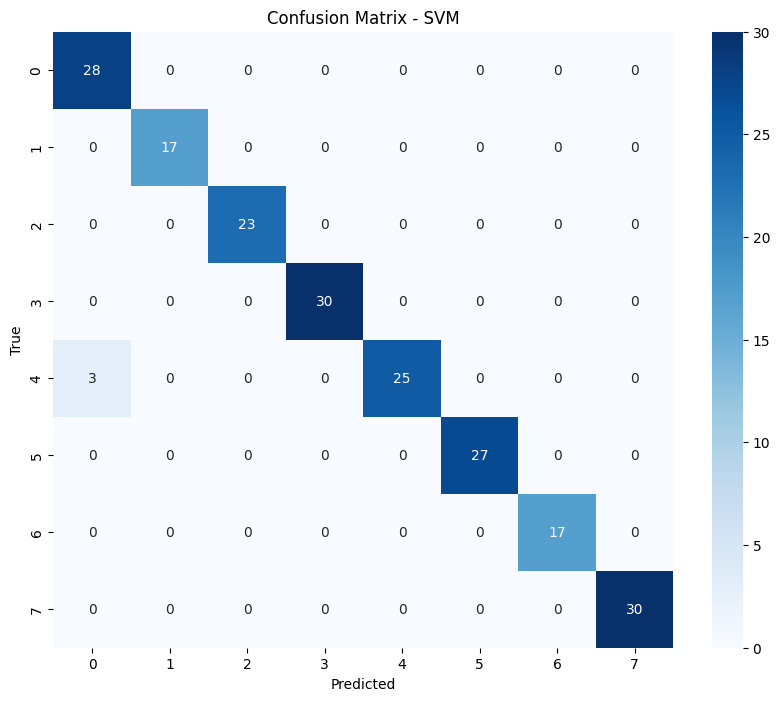

Model saved to model/sklearn_classifier/sklearn_classifier.pkl
Scaler saved to model/sklearn_classifier/scaler.pkl


In [56]:
## 11. Train sklearn Classifier for Full Features

def train_sklearn_classifier(X, y, model_type='SVM', model_save_path=sklearn_model_save_path):
    """Train a sklearn classifier using full feature set (pose + hands)"""
    # Create directories if they don't exist
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    
    # Convert to numpy arrays if they're not already
    X = np.array(X)
    y = np.array(y)
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, train_size=0.75, random_state=RANDOM_SEED)
    
    # Select and train the model
    if model_type.upper() == 'SVM':
        model = SVC(kernel='rbf', probability=True, random_state=RANDOM_SEED)
    else:  # Default to Random Forest
        model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_type} Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_type}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Save the model and scaler
    with open(model_save_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {model_save_path}")
    
    with open(scaler_save_path, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"Scaler saved to {scaler_save_path}")
    
    return model, scaler

# Train the sklearn classifier if we have data
if all_data_full and all_labels:
    # Convert string labels to numeric labels using the same mapping as keypoint classifier
    numeric_labels = [label_to_id[label] for label in all_labels]
    sklearn_model, scaler = train_sklearn_classifier(all_data_full, numeric_labels, model_type='SVM')
else:
    print("No data available for training sklearn classifier.")

In [57]:
def load_models():
    """Load the trained models for real-time prediction"""
    # Load keypoint classifier (PyTorch version)
    keypoint_model = None
    if os.path.exists(keypoint_model_save_path):
        # Define the model architecture
        class KeypointClassifier(nn.Module):
            def __init__(self, input_size, hidden_size_1, hidden_size_2, num_classes, dropout_1=0.2, dropout_2=0.4):
                super(KeypointClassifier, self).__init__()
                self.dropout1 = nn.Dropout(dropout_1)
                self.fc1 = nn.Linear(input_size, hidden_size_1)
                self.dropout2 = nn.Dropout(dropout_2)
                self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
                self.fc3 = nn.Linear(hidden_size_2, num_classes)
                self.relu = nn.ReLU()
            
            def forward(self, x):
                x = self.dropout1(x)
                x = self.relu(self.fc1(x))
                x = self.dropout2(x)
                x = self.relu(self.fc2(x))
                x = self.fc3(x)
                return x
        
        # Get number of classes from the training data or model
        if os.path.exists(keypoint_csv):
            y_dataset = np.loadtxt(keypoint_csv, delimiter=',', dtype='int32', usecols=(0))
            num_classes = len(np.unique(y_dataset))
        else:
            # Default to a reasonable number if CSV is not available
            num_classes = 10  # Adjust based on your application
        
        # Create model instance with the same architecture as during training
        model = KeypointClassifier(
            input_size=21 * 2,  # 21 hand landmarks x 2 coordinates
            hidden_size_1=20,
            hidden_size_2=10,
            num_classes=num_classes
        )
        
        # Load the trained parameters
        model.load_state_dict(torch.load(keypoint_model_save_path))
        model.eval()  # Set to evaluation mode
        
        keypoint_model = model
    
    # Load sklearn classifier and scaler (unchanged)
    sklearn_model = None
    scaler = None
    if os.path.exists(sklearn_model_save_path) and os.path.exists(scaler_save_path):
        with open(sklearn_model_save_path, 'rb') as f:
            sklearn_model = pickle.load(f)
        with open(scaler_save_path, 'rb') as f:
            scaler = pickle.load(f)
    
    # Load label mapping
    label_map_file = os.path.join(os.path.dirname(keypoint_csv), 'label_map.pkl')
    label_map = None
    if os.path.exists(label_map_file):
        with open(label_map_file, 'rb') as f:
            label_map = pickle.load(f)
    
    return keypoint_model, sklearn_model, scaler, label_map


def predict_with_pytorch_model(model, input_data):
    """Make predictions using the PyTorch keypoint classifier model"""
    # Convert input to PyTorch tensor
    input_tensor = torch.FloatTensor(input_data).unsqueeze(0)  # Add batch dimension
    
    # Ensure model is in evaluation mode
    model.eval()
    
    # Make prediction
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item()
    
    return predicted_class, confidence

In [58]:
def run_gesture_recognition():
    """Run real-time gesture recognition using both models"""
    # Load models
    keypoint_model, sklearn_model, scaler, label_map = load_models()
    
    if not keypoint_model or not sklearn_model or not scaler or not label_map:
        print("Error: Models not loaded. Please train the models first.")
        return
    
    # Get label mapping
    id_to_label = label_map['id_to_label']
    
    # Initialize webcam
    cap = cv2.VideoCapture(0)
    
    # Initialize prediction variables
    keypoint_pred_id = -1
    sklearn_pred_id = -1
    final_pred_id = -1
    
    # Initialize prediction history for smoothing
    prediction_history = []
    history_length = 5  # Number of frames to consider for smoothing
    
    # Set PyTorch model to evaluation mode
    keypoint_model.eval()
    
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose, \
         mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:
        
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                print("Failed to capture image from webcam.")
                break
                
            # Flip the image horizontally for a selfie-view display
            image = cv2.flip(image, 1)
            
            # Convert the BGR image to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Process the image for pose and hand detection
            pose_results = pose.process(image_rgb)
            hands_results = hands.process(image_rgb)
            
            # Copy original image for display
            display_image = image.copy()
            
            # Create a combined result object to pass to the feature extraction functions
            combined_results = type('CombinedResults', (), {
                'pose_landmarks': pose_results.pose_landmarks if pose_results.pose_landmarks else None,
                'multi_hand_landmarks': hands_results.multi_hand_landmarks if hands_results.multi_hand_landmarks else None,
                'multi_handedness': hands_results.multi_handedness if hands_results.multi_handedness else None
            })
            
            # Extract features for both models
            features_full = extract_landmarks(combined_results)
            normalized_features_full = normalize_landmarks(features_full)
            
            features_keypoint = extract_keypoint_format_features(combined_results)
            normalized_features_keypoint = normalize_keypoint_features(features_keypoint)
            
            # Make predictions with both models
            if keypoint_model and normalized_features_keypoint:
                # Prepare input for PyTorch model
                keypoint_input = torch.tensor([normalized_features_keypoint], dtype=torch.float32)
                
                # Run inference with PyTorch model
                with torch.no_grad():
                    keypoint_output = keypoint_model(keypoint_input)
                    
                # Get the predicted class and confidence
                keypoint_probs = torch.nn.functional.softmax(keypoint_output, dim=1)
                keypoint_pred_id = torch.argmax(keypoint_probs[0]).item()
                keypoint_pred_conf = keypoint_probs[0][keypoint_pred_id].item()
            
            if sklearn_model and scaler and normalized_features_full:
                # Prepare input for sklearn model
                sklearn_input = np.array([normalized_features_full])
                sklearn_input_scaled = scaler.transform(sklearn_input)
                
                # Get prediction and probability
                sklearn_pred_id = sklearn_model.predict(sklearn_input_scaled)[0]
                sklearn_pred_proba = sklearn_model.predict_proba(sklearn_input_scaled)[0]
                sklearn_pred_conf = sklearn_pred_proba[sklearn_pred_id]
            
            # Combine predictions from both models
            # Use a confidence-weighted voting system
            if keypoint_pred_id >= 0 and sklearn_pred_id >= 0:
                # Check if both models agree
                if keypoint_pred_id == sklearn_pred_id:
                    final_pred_id = keypoint_pred_id
                else:
                    # If they disagree, take the one with higher confidence
                    if keypoint_pred_conf > sklearn_pred_conf:
                        final_pred_id = keypoint_pred_id
                    else:
                        final_pred_id = sklearn_pred_id
                
                # Add to prediction history for smoothing
                prediction_history.append(final_pred_id)
                if len(prediction_history) > history_length:
                    prediction_history.pop(0)
                
                # Use majority voting from prediction history
                if prediction_history:
                    final_pred_id = max(set(prediction_history), key=prediction_history.count)
            
            # Draw landmarks on the image
            if pose_results.pose_landmarks:
                mp_drawing.draw_landmarks(
                    display_image,
                    pose_results.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    landmark_drawing_spec=pose_drawing_spec,
                    connection_drawing_spec=connection_drawing_spec)
            
            if hands_results.multi_hand_landmarks:
                for hand_landmarks in hands_results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(
                        display_image,
                        hand_landmarks,
                        mp_hands.HAND_CONNECTIONS,
                        landmark_drawing_spec=hand_drawing_spec,
                        connection_drawing_spec=connection_drawing_spec)
            
            # Display prediction results
            if final_pred_id >= 0:
                gesture_name = id_to_label.get(final_pred_id, "Unknown")
                
                # Display the prediction
                cv2.putText(display_image, f"Gesture: {gesture_name}", (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                
                # Display individual model predictions for debugging
                kp_name = id_to_label.get(keypoint_pred_id, "Unknown")
                sk_name = id_to_label.get(sklearn_pred_id, "Unknown")
                
                cv2.putText(display_image, f"Keypoint: {kp_name} ({keypoint_pred_conf:.2f})", (10, 70),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
                cv2.putText(display_image, f"sklearn: {sk_name} ({sklearn_pred_conf:.2f})", (10, 100),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            
            # Show the image
            cv2.imshow('Gesture Recognition', display_image)
            
            # Exit if ESC key is pressed
            if cv2.waitKey(5) & 0xFF == 27:
                break
    
    # Release resources
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
## 14. Main Function to Run the Program

def main():
    """Main function to run the program"""
    print("Enhanced Gesture Recognition System")
    print("----------------------------------")
    print("1. Collect training data")
    print("2. Train models")
    print("3. Run gesture recognition")
    print("0. Exit")
    choice = input("Enter your choice (0-3): ")
    
    if choice == '1':
        gesture_name = input("Enter gesture name (e.g., 'wave'): ")
        num_samples = int(input("Enter number of samples to collect (e.g., 100): "))
        collect_training_data(gesture_name, num_samples)
    elif choice == '2':
        # Combine all collected data
        all_data_full, all_data_keypoint, all_labels = combine_gesture_data()
        if all_data_full and all_data_keypoint and all_labels:
            # Create CSV for keypoint classifier
            label_to_id, unique_labels = create_keypoint_csv(all_data_keypoint, all_labels)
            
            # Train keypoint classifier
            print("Training keypoint classifier (TensorFlow model)...")
            keypoint_model = train_keypoint_classifier()
            
            # Train sklearn classifier
            print("\nTraining sklearn classifier...")
            numeric_labels = [label_to_id[label] for label in all_labels]
            sklearn_model, scaler = train_sklearn_classifier(all_data_full, numeric_labels)
            
            print("\nTraining complete!")
        else:
            print("No data available for training.")
    elif choice == '3':
        run_gesture_recognition()
    elif choice == '0':
        print("Exiting...")
        return
    else:
        print("Invalid choice. Please try again.")
    
    # Recursive call to main() to show the menu again
    main()

# Run the program if this file is executed directly
if __name__ == "__main__":
    main()

Enhanced Gesture Recognition System
----------------------------------
1. Collect training data
2. Train models
3. Run gesture recognition
0. Exit


Enter your choice (0-3):  3


C:\aiml\envs\py311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
C:\aiml\envs\py311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
C:\aiml\envs\py311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
C:\aiml\envs\py311\Lib\site-packages\google\protobuf\symbol_databas

Enhanced Gesture Recognition System
----------------------------------
1. Collect training data
2. Train models
3. Run gesture recognition
0. Exit


Enter your choice (0-3):  3


C:\aiml\envs\py311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
C:\aiml\envs\py311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
C:\aiml\envs\py311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
C:\aiml\envs\py311\Lib\site-packages\google\protobuf\symbol_databas

Enhanced Gesture Recognition System
----------------------------------
1. Collect training data
2. Train models
3. Run gesture recognition
0. Exit


Enter your choice (0-3):  3


C:\aiml\envs\py311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
C:\aiml\envs\py311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
C:\aiml\envs\py311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
C:\aiml\envs\py311\Lib\site-packages\google\protobuf\symbol_databas

Enhanced Gesture Recognition System
----------------------------------
1. Collect training data
2. Train models
3. Run gesture recognition
0. Exit


In [42]:
 # Release resources
# cap.release()
cv2.destroyAllWindows()